In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
pd.set_option('max_columns', 100)

In [10]:
training = pd.read_csv('train.csv')
print('training shape', training.shape)

training shape (2051, 81)


### Cleaning Training Dataset

In [11]:
training.columns = [co.lower().replace(' ','_').replace('/','_') for co in training.columns]

In [13]:
# changing NA to 'NA' in the variables with str value named NA
subset_training = ['alley','bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2',\
                   'fireplace_qu','garage_type' ,'garage_finish' ,'garage_qual' ,'garage_cond' ,'pool_qc' ,'fence'\
                   ,'misc_feature']
[training[x].fillna('NA', inplace = True) for x in subset_training]

In [14]:
num_null = list(training.loc[:, training.isnull().sum() !=0].columns)
print(num_null)

['lot_frontage', 'mas_vnr_type', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_yr_blt', 'garage_cars', 'garage_area']


In [15]:
# dropping the one column that has object type in the list
num_null.pop(1)

'mas_vnr_type'

In [17]:
# replacing null with zero in numeric columns
[training[x].fillna(0, inplace = True) for x in num_null]

In [18]:
# replacing null values with None in the object column
training['mas_vnr_type'] = training['mas_vnr_type'].fillna('None')

In [19]:
print('which ones still have nulls')
training.loc[:,training.isnull().sum() != 0].head(2)

which ones still have nulls


""
0
1


In [20]:
# by reading the data dictionary
ordinals = ['lot_shape', 'utilities', 'land_slope', 'exter_qual', 'exter_cond', 'bsmt_cond', 
            'bsmt_exposure', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive','pool_qc', 'fence']

In [21]:
test = pd.read_csv('test.csv')

In [22]:
# encoding ordinal variables
new_training = pd.DataFrame(training[ordinals])
training[ordinals] = pd.DataFrame({col: new_training[col].astype('category').cat.codes for \
                                   col in new_training}, index = training.index)

In [23]:
print('sale price averages, by condition_2:')
training['saleprice'].groupby(training['condition_2']).mean().round(3).sort_values(ascending = False)

sale price averages, by condition_2:


condition_2
PosN      395666.667
PosA      390666.667
RRAe      190000.000
Norm      181382.076
RRAn      136905.000
Feedr     129181.818
Artery    119050.000
RRNn       96750.000
Name: saleprice, dtype: float64

In [24]:
print('the dataframe of columns withouth null values:')
training.loc[:,training.isnull().sum() != 0].shape

the dataframe of columns withouth null values:


(2051, 0)

In [25]:
now_nulls = list(training.loc[:,training.isnull().sum() != 0].columns)

In [26]:
#since there is too many missing values, I'm gonna drop these columns entirely as I don't see much correlation with 
# y anyway
to_drop = list(training.loc[:,training.isnull().sum() != 0].columns)
training = training.drop(to_drop, axis = 1)
print('now we have training df of size: ', training.shape)

now we have training df of size:  (2051, 81)


### CLEANING TEST DATA NOW, repating steps done for training data:

In [27]:
test.columns = [co.lower().replace(' ','_').replace('/','_') for co in test.columns]
[test[x].fillna('NA', inplace = True) for x in subset_training] # run only once! commented to avoid problems
[test[x].fillna(0, inplace = True) for x in num_null]
test['mas_vnr_type'] = test['mas_vnr_type'].fillna('None')

In [28]:
new_test = pd.DataFrame(test[ordinals])
test[ordinals] = pd.DataFrame({col: new_test[col].astype('category').cat.codes for col \
                               in new_test}, index = test.index)


In [29]:
test = test.drop(to_drop, axis = 1)
print('test dataframe shape is now: ', test.shape)

test dataframe shape is now:  (879, 80)


### Exploratory Data Analysis

In [30]:
filtered = pd.DataFrame(training.corrwith(training['saleprice']))
filtered['abs'] = abs(filtered[0])
print(filtered.sort_values(by = 'abs', ascending  = False).head(9)) # above 0.6 correlation

                      0       abs
saleprice      1.000000  1.000000
overall_qual   0.800207  0.800207
gr_liv_area    0.697038  0.697038
exter_qual    -0.657939  0.657939
garage_area    0.649897  0.649897
garage_cars    0.647781  0.647781
kitchen_qual  -0.634168  0.634168
total_bsmt_sf  0.629303  0.629303
1st_flr_sf     0.618486  0.618486


In [31]:
highest_corrs = list(filtered.sort_values(by = 'abs', ascending  = False).index[:9])
print(highest_corrs)

['saleprice', 'overall_qual', 'gr_liv_area', 'exter_qual', 'garage_area', 'garage_cars', 'kitchen_qual', 'total_bsmt_sf', '1st_flr_sf']


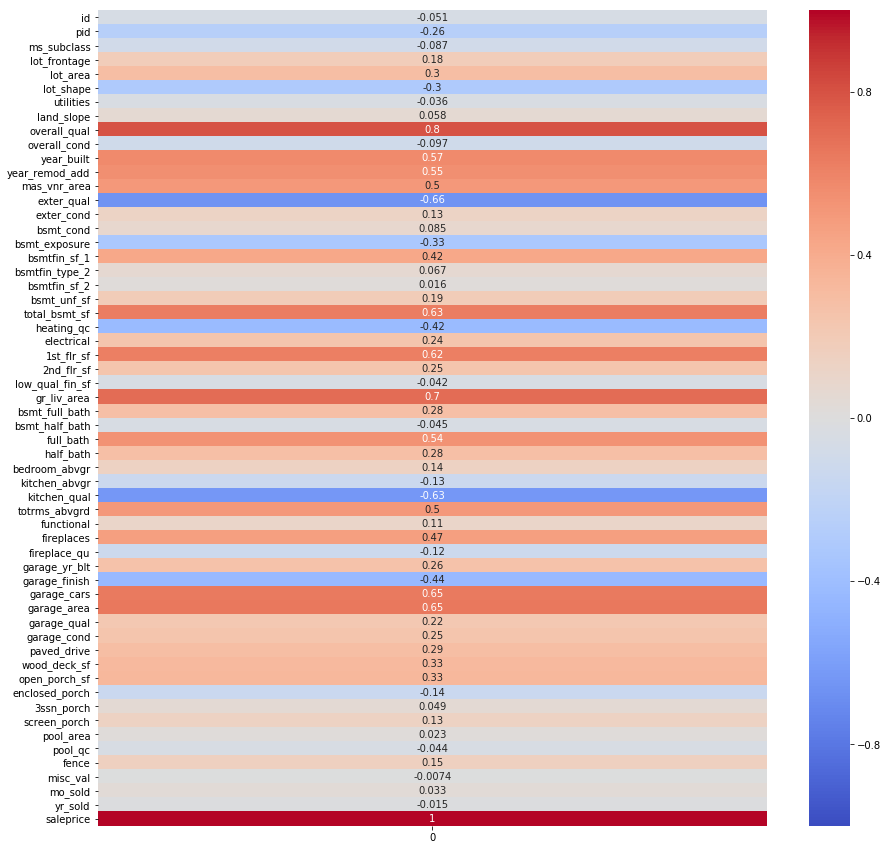

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(pd.DataFrame(filtered[0]), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm');

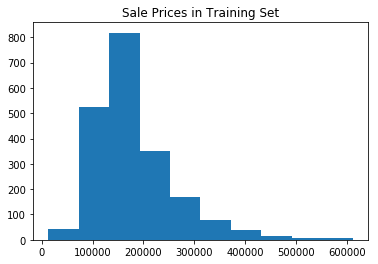

In [33]:
plt.hist(training['saleprice']);
plt.title('Sale Prices in Training Set');
# this tells me I need to log-transform y 

### Preparing the Model

In [34]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

In [35]:
# fetching the numerical columns only, that are not my target
features = [col for col in training._get_numeric_data().columns if col != 'saleprice']
X = training[features]
y = training['saleprice']

In [36]:
# doing the same thing for our test dataset to match dimensions with X
variables = [col for col in test._get_numeric_data().columns]
test_data = test[variables]
test_data.shape
print("X df shape {}, test df shape {}".format(X.shape, test_data.shape))

X df shape (2051, 57), test df shape (879, 57)


### Train/Test/Split & Scaling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [38]:
# scaling
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Power Transformer

In [39]:
# transforming the y:
pt_y = PowerTransformer() # includes rescaling
pt_y.fit(y_train.to_frame())
y_train_pt = pt_y.transform(y_train.to_frame()) 
y_test_pt = pt_y.transform(y_test.to_frame())

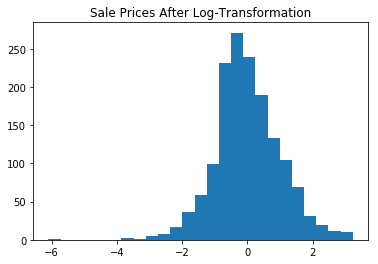

In [40]:
plt.hist(y_train_pt,bins=25);
plt.title('Sale Prices After Log-Transformation');

In [41]:
# instantiate the model
lr = LinearRegression()
lasso = LassoCV(cv = 5)
ridge = RidgeCV()
elastic = ElasticNetCV()

In [48]:
print('scoring the model: ')
print('linear regression: ', cross_val_score(lr, X_train, y_train_pt, cv = 5).mean())
print('lasso: ', cross_val_score(lasso, X_train_sc, y_train_pt[:,0], cv = 5).mean())
print('ridge: ',cross_val_score(ridge, X_train_sc, y_train_pt[:,0], cv = 5).mean())
print('elastic net: ', cross_val_score(elastic, X_train_sc, y_train_pt[:,0], cv = 5).mean())

scoring the model: 
linear regression:  0.8384020405468033
lasso:  0.838870215569979
ridge:  0.8395375990891312


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

elastic net:  0.8376891443600758


In [45]:
# model fitting and evaluation:
lasso.fit(X_train_sc, y_train_pt);
print('lasso score on training set:', ridge.score(X_train_sc, y_train_pt))
print('lasso score on test set: ', ridge.score(X_test_sc, y_test_pt))

ridge score on training set: 0.8790971722378448
ridge score on test set:  0.8787060146187728


In [49]:
# predicting:
ridge_pred = ridge.predict(X_test_sc)

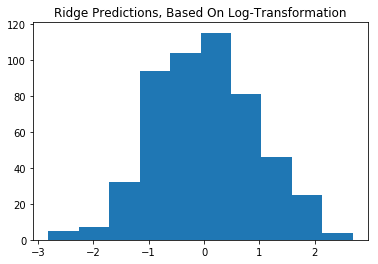

In [50]:
plt.hist(ridge_pred);
plt.title('ridge predictions, based on log-transformation'.title());

In [51]:
# to go back to originals:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
ridge_pred_reversed = pt_y.inverse_transform(ridge_pred.reshape(-1,1))

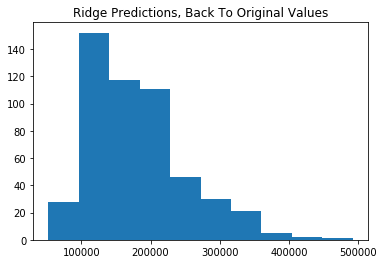

In [52]:
plt.hist(ridge_pred_reversed);
plt.title('ridge predictions, back to original values'.title());

In [53]:
print('ridge score on target: ', r2_score(y_test, ridge_pred_reversed))

ridge score on target:  0.8923168778461678


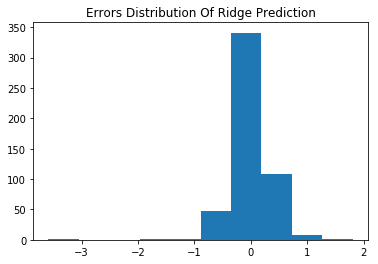

In [54]:
# plotting residuals
resid = y_test_pt - ridge_pred
plt.hist(resid);
plt.title('errors distribution of ridge prediction'.title());

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  


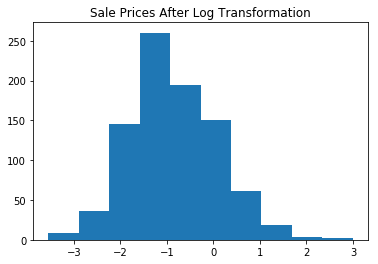

In [55]:
# predicting on the testing dataset
test_data_sc = ss.transform(test_data)
saleprice = ridge.predict(test_data_sc)
plt.hist(saleprice); #after rescaling
plt.title('sale prices after log transformation'.title());

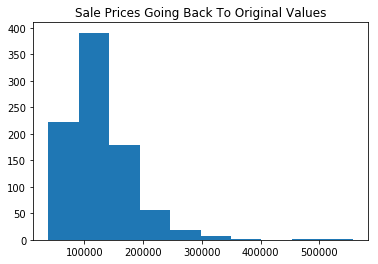

In [56]:
saleprice = pt_y.inverse_transform(saleprice)
plt.hist(saleprice); # after un-rescaling (going back to originals)
plt.title('sale prices going back to original values'.title());

In [57]:
saleprice = [i[0] for i in saleprice] # it was a list of lists
pd.DataFrame({'SalePrice' : saleprice}, index = test['id']).to_csv('second_prediction.csv')
pd.read_csv('second_prediction.csv').head()

,id,SalePrice
0,2658,98535.512996
1,2718,112508.401352
2,2414,164458.306314
3,1989,74837.001612
4,625,131045.001811


In [59]:
### Getting Coefficients: 
ridge_coefs = pd.DataFrame(ridge.coef_, columns = X_train.columns).T
ridge_coefs['originals'] = np.exp(ridge_coefs[0]) #getting original values, since it's log-transformed
ridge_coefs['abs_vals'] = ridge_coefs['originals'].abs()
ridge_coefs.sort_values(by = 'abs_vals', ascending = False).head(10)

,0,originals,abs_vals
overall_qual,0.277507,1.319835,1.319835
year_built,0.133453,1.142768,1.142768
gr_liv_area,0.117812,1.125033,1.125033
overall_cond,0.105758,1.111553,1.111553
garage_cars,0.083911,1.087532,1.087532
1st_flr_sf,0.080866,1.084225,1.084225
bsmt_full_bath,0.080052,1.083343,1.083343
year_remod_add,0.072831,1.075549,1.075549
fireplaces,0.070912,1.073486,1.073486
paved_drive,0.064507,1.066633,1.066633


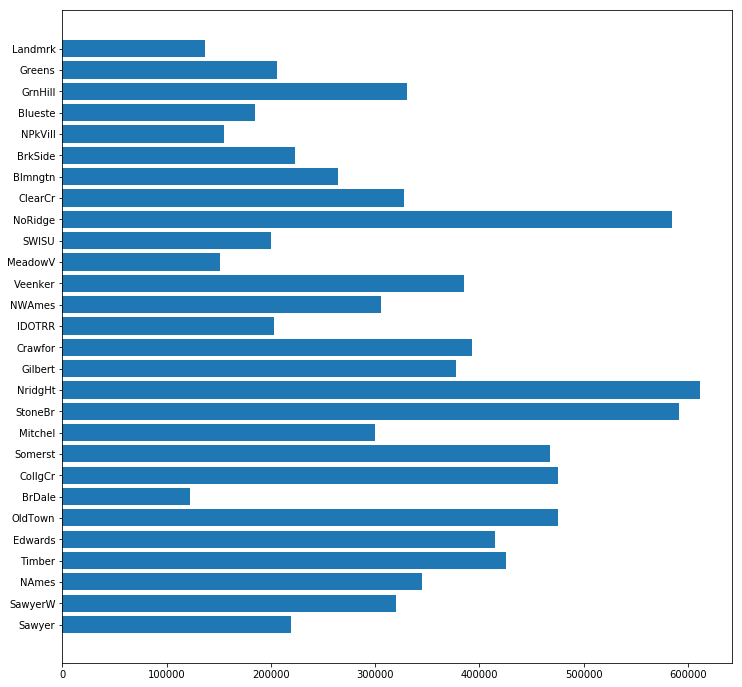

In [60]:
### plotting Training set SalePrices by neighborhood
plt.figure(figsize = (12,12))
plt.barh(training['neighborhood'], training['saleprice']);
#remove the %matplotlib inline from the top of the document first in order to be able to save!
plt.savefig('saleprice_by_neighborhood.png')

In [61]:
##P.S. no need to use GridSearch with RidgeCV because that latter has a parameter within it to test a few alphas, which 
#I can change. I could use GridSearch with Ridge however. 
#===================================================================================================